In [1]:
# !git clone https://github.com/muxspace/facial_expressions.git

In [21]:
# Import Libraries - Pandas, OS, Tensorflow, etc.
import pandas as pd
import os
import shutil 
import os.path
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

import numpy as np
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
from pathlib import Path


In [22]:
df = pd.read_csv("facial_expressions/data/legend.csv")

In [23]:
# Normalizes different methods of representing the same emotion through case (e.g. "ANGER", "Anger", and "anger")
df['emotion'] = [df['emotion'][i].lower() for i in df.index]
df

,Unnamed: 0,user.id,image,emotion
0,0,628,facial-expressions_2868588k.jpg,anger
1,1,628,facial-expressions_2868585k.jpg,surprise
2,2,628,facial-expressions_2868584k.jpg,disgust
3,3,628,facial-expressions_2868582k.jpg,fear
4,4,dwdii,Aaron_Eckhart_0001.jpg,neutral
...,...,...,...,...
13685,13685,jhamski,SharmilaTagore_80.jpg,happiness
13686,13686,jhamski,SharmilaTagore_81.jpg,happiness
13687,13687,jhamski,SharmilaTagore_82.jpg,happiness
13688,13688,jhamski,SharmilaTagore_83.jpg,happiness


In [24]:
# Look at data and remove unnecessary columns
del df['user.id']
df.head()

,Unnamed: 0,image,emotion
0,0,facial-expressions_2868588k.jpg,anger
1,1,facial-expressions_2868585k.jpg,surprise
2,2,facial-expressions_2868584k.jpg,disgust
3,3,facial-expressions_2868582k.jpg,fear
4,4,Aaron_Eckhart_0001.jpg,neutral


In [25]:
len(df)

13690

In [26]:
# Print out unique emotions after normalization to use in our classification
unique_emotions = list(df['emotion'].unique())
unique_emotions

['anger',
 'surprise',
 'disgust',
 'fear',
 'neutral',
 'happiness',
 'sadness',
 'contempt']

In [27]:
df = df.sample(frac = 1) 
train = df[0:int(len(df['image'])*0.6)]
valid = df[int(len(df['image'])*0.6):]
train = train.reset_index()
valid = valid.reset_index()

train

,index,Unnamed: 0,image,emotion
0,1233,1233,Bill_Gates_0009.jpg,neutral
1,3730,3730,George_Clooney_0005.jpg,happiness
2,10557,10557,Rod_Bryden_0001.jpg,neutral
3,6417,6417,John_Cornyn_0001.jpg,neutral
4,3733,3733,George_Clooney_0008.jpg,happiness
...,...,...,...,...
8209,11884,11884,Tom_Daschle_0022.jpg,neutral
8210,2748,2748,Dennis_Hastert_0006.jpg,happiness
8211,12869,12869,Dileep_7.jpg,sadness
8212,5439,5439,Jacques_Chirac_0030.jpg,neutral


In [28]:
# for index in train.index:
#     if (index % 100 == 0):
#         print(index)
#     source = "./facial_expressions/images/"+train['image'][index]
#     destination = './train/'+train['emotion'][index]+'/'+train['image'][index]
#     if (os.path.exists(source) and not (os.path.exists(destination))):
#         try:
#             dest = shutil.move(source, destination)
#         except:
#             os.mkdir('train/'+train['emotion'][index])
#             dest = shutil.move(source,destination)

In [29]:
# for index in valid.index:
#     if (index % 100 == 0):
#         print(index)
#     source = "./facial_expressions/images/"+valid['image'][index]
#     destination = './valid/'+valid['emotion'][index]+'/'+valid['image'][index]
    
#     if (os.path.exists(source) and not (os.path.exists(destination))):
#         try:
#             dest = shutil.move(source, destination)
#         except:
#             os.mkdir('valid/'+valid['emotion'][index])
#             dest = shutil.move(source,destination)

In [10]:
# Loading in training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [11]:
train_generator = train_datagen.flow_from_directory(
        './train_resize',
        target_size=(50, 50),
        batch_size=16,
        class_mode='categorical')

Found 31515 images belonging to 8 classes.


In [12]:
# Loading in testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_directory(
        './valid_resize',
        target_size=(50, 50),
        batch_size=16,
        class_mode='categorical')

Found 21850 images belonging to 8 classes.


In [13]:
# initialising sequential model and adding layers to it
# cnn = tf.keras.models.Sequential()
# cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=(3, 350, 350)))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# cnn.add(tf.keras.layers.Flatten())
# cnn.add(tf.keras.layers.Dense(128, activation='relu'))
# cnn.add(tf.keras.layers.Dense(64, activation='relu'))
# cnn.add(tf.keras.layers.Dense(8, activation='softmax'))

# Initializing sequential model that makes use of convolutional, pooling, and dense layers
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=(50, 50, 3), padding='same'))
#cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), padding='same'))
cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', padding = 'same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding = 'same'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding = 'same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation='relu'))
cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(8, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
# config = tf.ConfigProto(
#         device_count = {'GPU': 0}
#     )
# sess = tf.Session(config=config)

In [15]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        13856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [ ]:
# finally compile and train the cnn
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.fit(x=train_generator, validation_data=test_generator, epochs=12)

Epoch 1/12
1970/1970 [==============================] - 203s 103ms/step - loss: 1.2934 - acc: 0.4718 - val_loss: 1.3624 - val_acc: 0.5011
Epoch 2/12
1970/1970 [==============================] - 149s 75ms/step - loss: 0.8164 - acc: 0.6805 - val_loss: 1.6836 - val_acc: 0.5395
Epoch 3/12
1970/1970 [==============================] - 413s 210ms/step - loss: 0.5649 - acc: 0.7833 - val_loss: 1.7841 - val_acc: 0.5578
Epoch 4/12
1970/1970 [==============================] - 564s 286ms/step - loss: 0.4495 - acc: 0.8296 - val_loss: 2.1945 - val_acc: 0.5563
Epoch 5/12
1970/1970 [==============================] - 451s 229ms/step - loss: 0.3791 - acc: 0.8568 - val_loss: 2.3186 - val_acc: 0.5590
Epoch 6/12
1970/1970 [==============================] - 492s 250ms/step - loss: 0.3460 - acc: 0.8693 - val_loss: 2.6927 - val_acc: 0.5660
Epoch 7/12
1970/1970 [==============================] - 572s 290ms/step - loss: 0.3158 - acc: 0.8802 - val_loss: 2.7344 - val_acc: 0.5714
Epoch 8/12
1970/1970 [=============

In [ ]:
# !mkdir model
cnn.save('model/my_model')

In [31]:
import cv2
import tensorflow as tf

CATEGORIES = ["Dog", "Cat"]  # will use this to convert prediction num to string value

def prepare(filepath):
    IMG_SIZE = 50  # 50 in txt-based
    img_array = cv2.imread(filepath)  # read in the image, convert to grayscale
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  # return the image with shaping that TF wants.

prediction = cnn.predict([prepare('facial_expressions/test/52b.jpg')]) 

In [32]:
print(prediction)

[[0. 0. 0. 0. 0. 1. 0. 0.]]


In [30]:
new_model = tf.keras.models.load_model('./model/my_model')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [50]:
unique_count = {'anger' : 0,
 'surprise' : 0,
 'disgust' : 0,
 'fear' : 0,
 'neutral' : 0,
 'happiness' : 0,
 'sadness' : 0,
 'contempt' : 0}
for test_file in os.listdir("./test_resize"):
    #print(test_file)
    prediction = new_model.predict([prepare("./test_resize/" + test_file)])
    prediction_list = prediction.tolist()
    prediction_list = prediction_list[0]
    max_value = max(prediction_list)
    maximum = -1
    for index in prediction_list:
        if (maximum < index):
            maximum = index
    unique_emotion = unique_emotions[prediction_list.index(maximum)]
    
    unique_count[unique_emotion] += 1

for key in unique_count.keys():
    print(key + ":" + str(unique_count[key]))
    

anger:14
surprise:0
disgust:1
fear:0
neutral:110
happiness:100
sadness:19
contempt:19


In [64]:
unique_pictures = {'anger' : [],
 'surprise' : [],
 'disgust' : [],
 'fear' : [],
 'neutral' : [],
 'happiness' : [],
 'sadness' : [],
 'contempt' : []}

for test_file in os.listdir("./test_resize"):
    #print(test_file)
    prediction = new_model.predict([prepare("./test_resize/" + test_file)])
    prediction_list = prediction.tolist()
    prediction_list = prediction_list[0]
    max_value = max(prediction_list)
    maximum = -1
    for index in prediction_list:
        if (maximum < index):
            maximum = index
    unique_emotion = unique_emotions[prediction_list.index(maximum)]
    
    unique_pictures[unique_emotion].append("./test_resize/" + test_file)

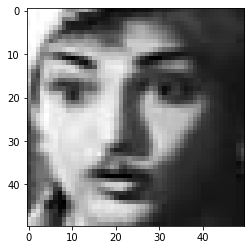

In [75]:
plt.imshow(cv2.imread(unique_pictures['sadness'][8]))

In [61]:
val = cv2.imread(unique_pictures['anger'][0])
print(val)

None
